## <strong>Previsão preço de fechamento do indice bovespa - IBOV</strong>

O objetivo é utilizar machine learning para prever o preço de fechamento do indice bovespa - IBOV.

Componentes do Grupo

1.   Anderson Gleidson Marques
2.   Eden de Oliveira Santana
3.   Glayson De Melo Freitas

Os dados utilizados são extraidos do yahoo finance. 

O dataset possui dados de 01/2010 a 12/2020

## <strong>Instalando e importando as bibliotecas</strong>

In [22]:
#Instalação do Yahoo Finance para obter os dados do incide IBOV
!pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


In [23]:
#Importação da bibliotecas
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn import datasets, linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as pl
import seaborn as sns
sns.set()

import pandas_datareader.data as yahoo_finance
import yfinance as yf

yf.pdr_override()

## <strong>Obtendo os dados do Yahoo Finance</strong>

In [24]:
#Obtendo as coações do indice IBOV de Janeiro de 2010 a Dezembro de 2020
ibov = yahoo_finance.get_data_yahoo('^BVSP',start="2010-01-01",end="2020-12-11")
ibov = ibov.reset_index()
ibov.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
2699,2020-12-04,112294.0,113864.0,112294.0,113682.0,113682.0,8892900
2700,2020-12-07,113751.0,114531.0,112629.0,113625.0,113625.0,9633900
2701,2020-12-08,113590.0,114381.0,112820.0,113571.0,113571.0,8810900
2702,2020-12-09,113799.0,114020.0,112567.0,112722.0,112722.0,8431100
2703,2020-12-10,113002.0,115262.0,112732.0,114992.0,114992.0,11803600


In [25]:
ibov.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

## <strong>Exibindo gráfico com preço de fechamento do periodo</strong>

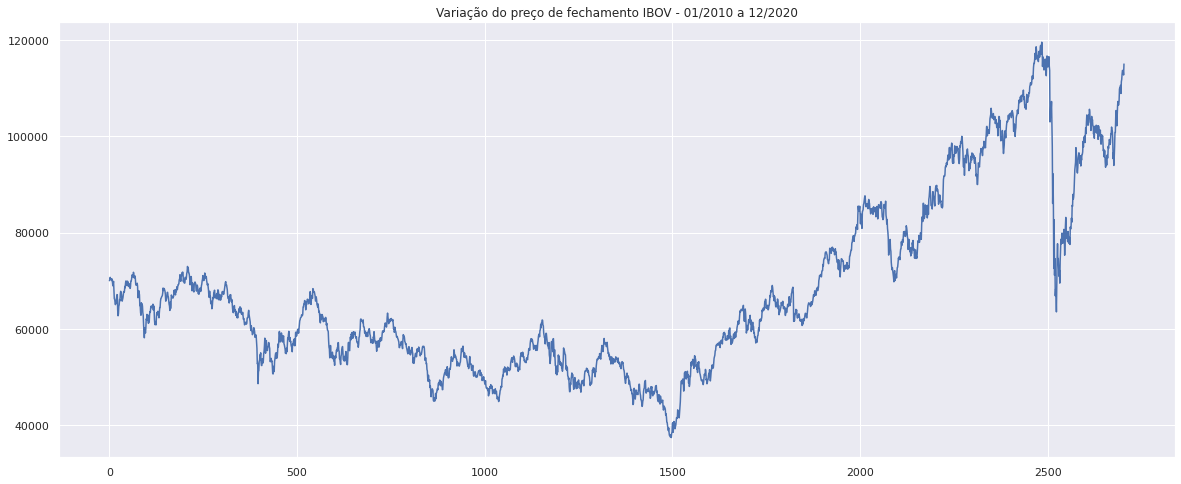

In [7]:
#Gráfico com a variação do preço de fechamento IBOV
pl.title('Variação do preço de fechamento IBOV - 01/2010 a 12/2020')
ibov["Close"].plot(figsize=(20,8));

## <strong>Tratamento dos dados e criação de novas features</strong>

In [8]:
# Criando campos de média móvel
# Os campos foram criados a partir do valor de fechamento da ação

#Campo com média móvel com variação de 5 dias pregão
ibov['MM_5_day'] = ibov['Close'].rolling(5).mean()

# Campo com  média móvel com variação de 21 de pregrão
ibov['MM_21_day'] = ibov['Close'].rolling(21).mean()

ibov.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,MM_5_day,MM_21_day
0,2010-01-04,68587.0,70081.0,68587.0,70045.0,70045.0,1655400,NaN,NaN
1,2010-01-05,70046.0,70595.0,69928.0,70240.0,70240.0,1984200,NaN,NaN
2,2010-01-06,70237.0,70937.0,70016.0,70729.0,70729.0,2243600,NaN,NaN
3,2010-01-07,70723.0,70723.0,70045.0,70451.0,70451.0,1555000,NaN,NaN
4,2010-01-08,70455.0,70766.0,70158.0,70263.0,70263.0,1634400,70345.6,NaN
5,2010-01-11,70267.0,71068.0,70158.0,70433.0,70433.0,1569000,70423.2,NaN
6,2010-01-12,70429.0,70429.0,69284.0,70076.0,70076.0,1628600,70390.4,NaN
7,2010-01-13,70081.0,70626.0,69535.0,70385.0,70385.0,1818800,70321.6,NaN
8,2010-01-14,70377.0,70508.0,69661.0,69801.0,69801.0,1830200,70191.6,NaN
9,2010-01-15,69780.0,69788.0,68695.0,68978.0,68978.0,1648400,69934.6,NaN


In [9]:
#Como estamos tentando prever o valor de fechamento da IBOV, vamos fazer um shift com valor de fechamento da ação ou seja, vamos "empurrar" o valor da cotação. 
#Ex: O valor de fechamento do dia 12/01/2010, vamos "empurrar" para 11/01/2010.

#Isso é necessário pois estamos tentando prever o fechamento do próximo dia

ibov['Close'] = ibov['Close'].shift(-1)

ibov.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,MM_5_day,MM_21_day
0,2010-01-04,68587.0,70081.0,68587.0,70240.0,70045.0,1655400,NaN,NaN
1,2010-01-05,70046.0,70595.0,69928.0,70729.0,70240.0,1984200,NaN,NaN
2,2010-01-06,70237.0,70937.0,70016.0,70451.0,70729.0,2243600,NaN,NaN
3,2010-01-07,70723.0,70723.0,70045.0,70263.0,70451.0,1555000,NaN,NaN
4,2010-01-08,70455.0,70766.0,70158.0,70433.0,70263.0,1634400,70345.6,NaN
5,2010-01-11,70267.0,71068.0,70158.0,70076.0,70433.0,1569000,70423.2,NaN
6,2010-01-12,70429.0,70429.0,69284.0,70385.0,70076.0,1628600,70390.4,NaN
7,2010-01-13,70081.0,70626.0,69535.0,69801.0,70385.0,1818800,70321.6,NaN
8,2010-01-14,70377.0,70508.0,69661.0,68978.0,69801.0,1830200,70191.6,NaN
9,2010-01-15,69780.0,69788.0,68695.0,69401.0,68978.0,1648400,69934.6,NaN


In [10]:
#Removendo as colunas com valores nulos. Neste caso vamos perder 21 linhas, devido ao procedimento do shift, feito no passo anterior
ibov.dropna(inplace=True)

ibov.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,MM_5_day,MM_21_day
20,2010-02-02,66589.0,67321.0,66539.0,67109.0,67163.0,1587800,65959.0,68415.238095
21,2010-02-03,67163.0,67347.0,66774.0,63934.0,67109.0,1765000,66366.8,68275.428571
22,2010-02-04,67100.0,67100.0,63750.0,62763.0,63934.0,2262400,66036.0,67975.142857
23,2010-02-05,63934.0,64001.0,61341.0,63153.0,62763.0,3053000,65508.2,67595.809524
24,2010-02-08,62760.0,63923.0,62728.0,64718.0,63153.0,1875600,64824.4,67248.285714
25,2010-02-09,63164.0,65526.0,63164.0,65051.0,64718.0,1357400,64335.4,66984.238095
26,2010-02-10,64721.0,65170.0,64320.0,66129.0,65051.0,891000,63923.8,66727.952381
27,2010-02-11,65050.0,66145.0,64344.0,65855.0,66129.0,1259000,64362.8,66540.000000
28,2010-02-12,66129.0,66133.0,65123.0,67285.0,65855.0,873200,64981.2,66324.285714
29,2010-02-17,65863.0,67542.0,65863.0,67836.0,67285.0,0,65807.6,66204.476190


In [11]:
#Reindexando o data frame ibov
ibov = ibov.reset_index(drop=True)
ibov.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,MM_5_day,MM_21_day
0,2010-02-02,66589.0,67321.0,66539.0,67109.0,67163.0,1587800,65959.0,68415.238095
1,2010-02-03,67163.0,67347.0,66774.0,63934.0,67109.0,1765000,66366.8,68275.428571
2,2010-02-04,67100.0,67100.0,63750.0,62763.0,63934.0,2262400,66036.0,67975.142857
3,2010-02-05,63934.0,64001.0,61341.0,63153.0,62763.0,3053000,65508.2,67595.809524
4,2010-02-08,62760.0,63923.0,62728.0,64718.0,63153.0,1875600,64824.4,67248.285714
5,2010-02-09,63164.0,65526.0,63164.0,65051.0,64718.0,1357400,64335.4,66984.238095
6,2010-02-10,64721.0,65170.0,64320.0,66129.0,65051.0,891000,63923.8,66727.952381
7,2010-02-11,65050.0,66145.0,64344.0,65855.0,66129.0,1259000,64362.8,66540.000000
8,2010-02-12,66129.0,66133.0,65123.0,67285.0,65855.0,873200,64981.2,66324.285714
9,2010-02-17,65863.0,67542.0,65863.0,67836.0,67285.0,0,65807.6,66204.476190


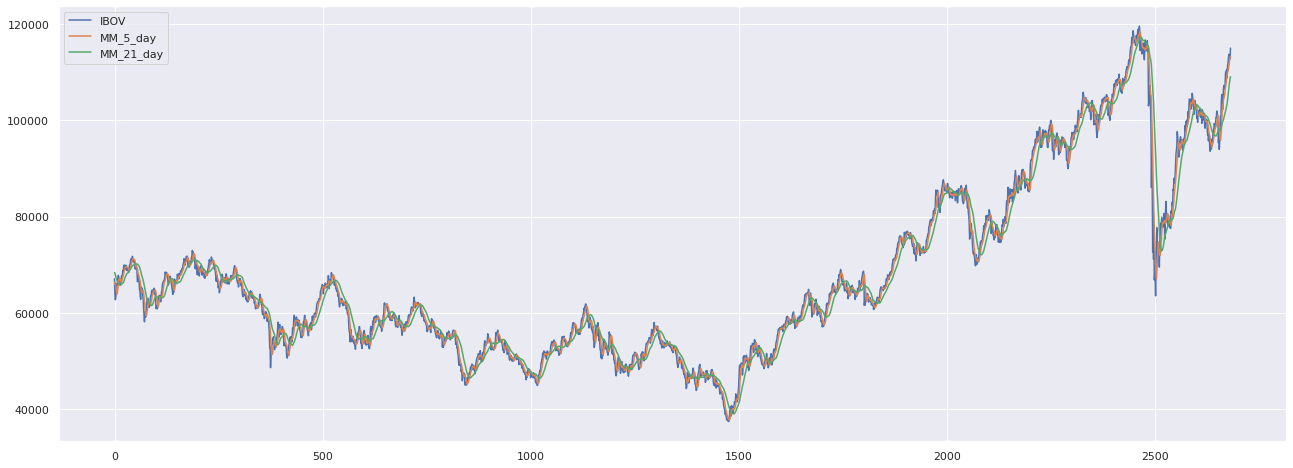

In [12]:
#Gerando o gráfico com as médias móveis em relação ao valor de fechamento da cotação, durante todo o periodo analisado
ibov["Close"].plot(figsize=(22,8), label="IBOV")
ibov["MM_5_day"].plot(label="MM_5_day")
ibov["MM_21_day"].plot(label="MM_21_day")
pl.legend();

## <strong>Separando as Features a labels do modelo</strong>

In [13]:
#Sepadando features e as labels 
features = ibov.drop(['Date','Close','Adj Close'],1)
labels = ibov['Close']

In [14]:
# Utilizando o Kbest, para descobrir qual são as melhores features para o modelo
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

features_list = ('Open','Volume','Adj Close','MM_5_day','MM_21_day')

#Selecionar os recursos de acordo com as pontuações mais altas
k_best_features = SelectKBest(k='all')

#Ajusta aos dados e transformá-los
k_best_features.fit_transform(features, labels)

#Scores das features
k_best_features_score = k_best_features.scores_

raw_pairs = zip(features_list[1:], k_best_features_score)

ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

#Exibindo as melhores features
print ("Best features:")
print (k_best_features_final)

Best features:
{'MM_5_day': 382.8535362380794, 'Adj Close': 369.04007790860135, 'Volume': 232.0301803913857, 'MM_21_day': 1.914659380013251}


In [15]:
#Vamos deixar somente as melhores features, conforme listado no passo anterior
features = ibov.drop(['Open', 'Date','Close','MM_21_day'],1)

## <strong>Normalizando os dados</strong>

In [16]:
#Normalizando as features 

scaler = MinMaxScaler().fit(features)

features_scale = scaler.transform(features)

#Exibindo as features normalizadas
print (features_scale)

[[0.35911331 0.36383262 0.36164377 0.08226943 0.34920588]
 [0.35943209 0.36673164 0.36098548 0.09145078 0.35426119]
 [0.35640372 0.32942686 0.3222806  0.1172228  0.35016041]
 ...
 [0.93793678 0.93240976 0.9280394  0.4991658  0.92832314]
 [0.93609769 0.93476598 0.92738111 0.45652332 0.93386688]
 [0.93167161 0.93164491 0.91703137 0.43684456 0.93611809]]


## <strong>Separando os dados em treino, teste e validação</strong>

In [17]:
#Separando os dados de treino e teste

_total = len(ibov)
_treino = _total -800
_teste = _total -15
_validacao  = _treino - _teste

x_train = features_scale[:_treino]
x_test = features_scale[_treino:_teste]

y_train = labels[:_treino]
y_test = labels[_treino:_teste]


## <strong>Funções auxiliares</strong>

In [21]:
# Função para imprimir o Coeficiente de determinação
def printCD(cd):
    print(f'Coeficiente de determinação:{cd * 100:.2f}')

## <strong>Treinamento do modelo</strong>

In [20]:
#treinamento utilizando Rede Neural

rn = MLPRegressor(max_iter=2000)

rn.fit(x_train,y_train)

pred = rn.predict(x_test)

cd = rn.score(x_test,y_test)

printCD(cd)

Coeficiente de determinação:-2.91


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
#treinamento utilizando Rede Neural com hyper parameters

rn = MLPRegressor()

_parameters = {
    'hidden_layer_sizes': [(i,) for i in list(range(1,21))],
    'activation':['tanh','relu'],
    'solver':['sgd','adam','lbfgs'],
    'alpha':[0.0001,0.05],
    'learning_rate':['constant','adaptive']
}

search = GridSearchCV(rn,_parameters, n_jobs=-1,cv=5)

search.fit(x_train,y_train)

clf = search.best_estimator_

pred = search.score(x_test,y_test)

cd = search.score(x_test,y_test)

printCD(cd)

Coeficiente de determinação:98.82


In [ ]:
#treinamento utilizando Regressão linear

lr = linear_model.LinearRegression()

lr.fit(x_train, y_train)
pred = lr.predict(x_test)

cd = r2_score(y_test, pred)

printCD(cd)

Coeficiente de determinação:98.82


## <strong>Realizando previsão com o melhor modelo</strong>

In [ ]:
#Realizando a Previsão - Regressão linear
#Como a regração linear teve um Coeficiente de determinação:97.48, 
#foi o melhor entre os três

previsao = features_scale[_teste:_total]

pregao_geral = ibov['Date']

pregao = pregao_geral[_teste:_total]

fechamento_full = ibov['Close']
fechamento = fechamento_full[_teste:_total]

pred = lr.predict(previsao)

ibov_previsao = pd.DataFrame({'Data':pregao,'real':fechamento,'previsao':pred})
ibov_previsao['real'] = ibov_previsao['real'].shift(+1)
ibov_previsao.dropna(inplace=True)
ibov_previsao.set_index('Data', inplace=True)

print(ibov_previsao)

                real       previsao
Data                               
2020-11-18  106517.0  107023.123491
2020-11-19  107379.0  109291.164456
2020-11-23  109786.0  110095.507200
2020-11-24  110133.0  109565.992407
2020-11-25  110227.0  109578.491358
2020-11-26  110575.0  110433.122800
2020-11-27  108888.0  109656.578859
2020-11-30  111335.0  111659.787210
2020-12-01  111814.0  112454.340161
2020-12-02  112919.0  112465.236538
2020-12-03  113682.0  113207.474584
2020-12-04  113625.0  113641.669186
2020-12-07  113571.0  113255.709175
2020-12-08  112722.0  114137.534135


## <strong>Gáfico comparando preço real com preço previsto</strong>

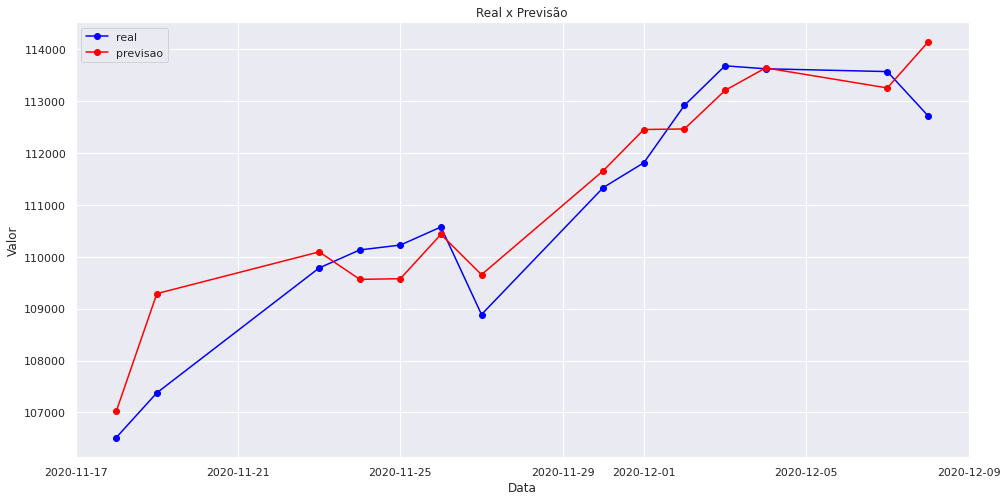

In [ ]:
#Grafico comprativo Real X Previsto

pl.figure(figsize=(16,8))
pl.title('Real x Previsão')
pl.plot(ibov_previsao['real'],label="real",color='blue', marker='o')
pl.plot(ibov_previsao['previsao'],label="previsao",color='red', marker='o')
pl.xlabel('Data')
pl.ylabel('Valor')
leg = pl.legend()